<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 2.7.16
IPython 5.8.0

numpy 1.16.5
scipy 1.2.1
pandas 0.24.2
matplotlib 2.2.3
statsmodels 0.10.1
sklearn 0.20.3

compiler   : MSC v.1500 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 60 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   :


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Поменяйте на свой путь к данным
PATH_TO_RAW_DATA = '../data/raw'
PATH_TO_INTERIM_DATA = '../data/interim'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_INTERIM_DATA, 
                       'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_INTERIM_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
knn_train_score = np.mean(cross_val_score(knn, X_train, y_train, cv=skf))
print('Score on train: {}'.format(knn_train_score))
knn.fit(X_train, y_train)
knn_valid_score = knn.score(X_valid, y_valid)
print('Score on valid: {}'.format(knn_valid_score))

Score on train: 0.564718887006
Score on valid: 0.584024650391


**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [12]:
def write_answer_to_file(answer, file_address):
    if isinstance(answer, list):
        answer_str = ' '.join(map(str, answer))
    else:
        answer_str = str(answer)
    with open(file_address, 'w') as out_f:
        out_f.write(answer_str)

def round_3(x):
    return round(x, 3)

In [13]:
write_answer_to_file(map(round_3, [knn_train_score, knn_valid_score]), 'answer4_1.txt')

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
forest = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=17, n_jobs=-1)
forest.fit(X_train, y_train)
forest_oob_score = forest.oob_score_
print('OOB score: {}'.format(forest_oob_score))
forest_valid_score = forest.score(X_valid, y_valid)
print('Score on valid: {}'.format(forest_valid_score))

OOB score: 0.72119487909
Score on valid: 0.736667456743


**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [16]:
write_answer_to_file(map(round_3, [forest_oob_score, forest_valid_score]),
                     'answer4_2.txt')

In [17]:
!type answer4_2.txt

0.721 0.737


**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [18]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [19]:
logit = LogisticRegression(random_state=17, n_jobs=-1)
logit_train_score = np.mean(cross_val_score(logit, X_train, y_train, cv=skf))
print('Score on train: {}'.format(logit_train_score))
logit.fit(X_train, y_train)
logit_valid_score = logit.score(X_valid, y_valid)
print('Score on valid: {}'.format(logit_valid_score))

Score on train: 0.761026754367
Score on valid: 0.781701825077


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [20]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, cv=skf, multi_class='multinomial', random_state=17, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)
logit_cv_scores1 = logit_grid_searcher1.scores_.values()[0]

Wall time: 8.26 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [21]:
logit_mean_cv_scores1 = np.apply_along_axis(np.mean, 0, logit_cv_scores1)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [22]:
print('C: {}, score: {}'.format( *max(zip(logit_c_values1, logit_mean_cv_scores1), key=lambda x: x[1])) )

C: 1.0, score: 0.759097498893


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

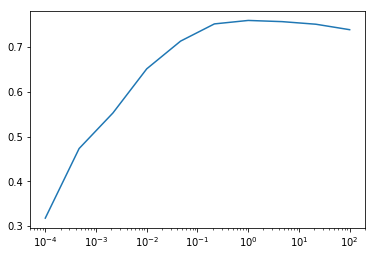

In [23]:
plt.plot(logit_c_values1, logit_mean_cv_scores1)
plt.xscale('log')

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [24]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, cv=skf, multi_class='multinomial', random_state=17, n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)
logit_cv_scores2 = logit_grid_searcher2.scores_.values()[0]

Wall time: 22.9 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [25]:
logit_mean_cv_scores2 = np.apply_along_axis(np.mean, 0, logit_cv_scores2)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

*Здесь не вполне понятна трактовка задания. Если имеется в виду лучшее среднее значение (а иначе зачем мы считали средние значения), то ответ на задание 4.3 будет зачтен, но на задание 4.7, где это значение `C` тоже используется - нет. А для задания 4.7 нужно значение `C` с другой трактовкой, буквальной - лучшее значение среди всех `C` и всех фолдов кросс-валидации. Причем с таким `C` качество классификатора будет хуже, но зато ответ принимается. Поэтому вычислим и сохраним оба этих значения.*

In [26]:
logit_max_C, logit_max_score = max(zip(logit_c_values2, np.max(logit_cv_scores2, axis=0)), key=lambda x: x[1])
logit_max_C, logit_max_score

(3.7315789473684213, 0.770966758157975)

In [27]:
logit_best_C, logit_best_score = max(zip(logit_c_values2, logit_mean_cv_scores2), key=lambda x: x[1])
print('C: {}, score: {}'.format(logit_best_C, logit_best_score))

C: 0.463157894737, score: 0.758689694386


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

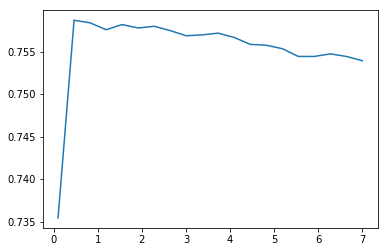

In [28]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [29]:
logit_valid_acc = accuracy_score(logit_grid_searcher2.predict(X_valid), y_valid)
logit_valid_acc

0.7748281583313581

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [30]:
write_answer_to_file(map(round_3, [logit_best_score, logit_valid_acc]),
                     'answer4_3.txt')

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [31]:
from sklearn.svm import LinearSVC

In [32]:
svm = LinearSVC(C=1, random_state=17)
svm_train_score = np.mean(cross_val_score(svm, X_train, y_train, cv=skf))
print('Score on train: {}'.format(svm_train_score))
svm.fit(X_train, y_train)
svm_valid_score = svm.score(X_valid, y_valid)
print('Score on valid: {}'.format(svm_valid_score))

Score on train: 0.752797672301
Score on valid: 0.776961365252


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [33]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, cv=skf)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 37.8 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [34]:
svm_best_C = svm_grid_searcher1.best_params_['C']
svm_best_score = svm_grid_searcher1.best_score_
print('C: {}, score: {}'.format(svm_best_C, svm_best_score))

C: 3333.3334, score: 0.68451534241


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

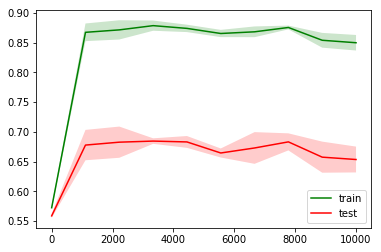

In [35]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`.**

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [36]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, cv=skf)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 5s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [37]:
svm_best_C = svm_grid_searcher2.best_params_['C']
svm_best_score = svm_grid_searcher2.best_score_
print('C: {}, score: {}'.format(svm_best_C, svm_best_score))

C: 0.104344827586, score: 0.764681975208


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

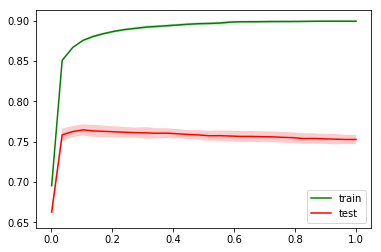

In [38]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [39]:
svm_valid_acc = accuracy_score(svm_grid_searcher2.best_estimator_.predict(X_valid), y_valid)
svm_valid_acc

0.7807537331121118

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [40]:
write_answer_to_file(map(round_3, [svm_best_score, svm_valid_acc]),
                     'answer4_4.txt')

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [41]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, test_size=test_size, 
                                                          random_state=random_state, stratify=y)
    
    cv_acc = np.mean(cross_val_score(estimator, X_train, y_train, cv=cv))
    estimator.fit(X_train, y_train)
    holdout_acc = estimator.score(X_valid, y_valid)
    return cv_acc, holdout_acc

**Убедитесь, что функция работает.**

In [42]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_INTERIM_DATA, 'X_sparse_10users.pkl'), 
                 os.path.join(PATH_TO_INTERIM_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7646853244550981, 0.7807537331121118)

*Функция работает, это GridSearchCV как-то странно считает среднее:*

In [43]:
tmp = svm_grid_searcher2.cv_results_
print(tmp['mean_test_score'])
print(np.mean([tmp['split0_test_score'], tmp['split1_test_score'], tmp['split2_test_score']], axis=0))

[0.6628734  0.75848405 0.76254826 0.76468198 0.76336111 0.76285308
 0.76224345 0.76173542 0.76122739 0.76092258 0.76051616 0.76061776
 0.75980492 0.75899207 0.75838244 0.75736639 0.75746799 0.75706157
 0.75655355 0.75655355 0.75624873 0.75604552 0.75543589 0.75502947
 0.75391181 0.75401341 0.75350539 0.75320057 0.75279415 0.75279415]
[0.66287595 0.75848629 0.76255115 0.76468532 0.76336496 0.76285726
 0.76224682 0.76173845 0.7612301  0.76092624 0.76051878 0.7606205
 0.75980798 0.7589955  0.75838602 0.75737007 0.75747216 0.75706563
 0.75655765 0.75655765 0.75625262 0.75604927 0.75543942 0.75503292
 0.75391534 0.75401728 0.75350915 0.75320473 0.75279792 0.75279767]


**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [44]:
#!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
#!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
#!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
#!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [45]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_INTERIM_DATA, 'X_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_INTERIM_DATA, 'y_10users_s{}_w{}.pkl'.format(session_length, window_size))
        cv_acc, holdout_acc = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3)
        print('Session length {}, window size {}: CV accuracy = {}, holdout accuracy = {}'.format(
            session_length, window_size, cv_acc, holdout_acc))

Session length 15, window size 10: CV accuracy = 0.823821495528, holdout accuracy = 0.840483526902
Session length 10, window size 10: CV accuracy = 0.764685324455, holdout accuracy = 0.780753733112
Session length 15, window size 7: CV accuracy = 0.847940376984, holdout accuracy = 0.854322216692
Session length 10, window size 7: CV accuracy = 0.797016146373, holdout accuracy = 0.807366849179
Session length 7, window size 7: CV accuracy = 0.752989111483, holdout accuracy = 0.761738841878
Session length 15, window size 5: CV accuracy = 0.868001372554, holdout accuracy = 0.875296348981
Session length 10, window size 5: CV accuracy = 0.815924720532, holdout accuracy = 0.824561403509
Session length 7, window size 5: CV accuracy = 0.774058674563, holdout accuracy = 0.785324798483
Session length 5, window size 5: CV accuracy = 0.72528306504, holdout accuracy = 0.736249407302
Wall time: 18.7 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [46]:
write_answer_to_file(map(round_3, [0.868, 0.875]),
                     'answer4_5.txt')

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :)**

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

*Качество классификации увеличивается с ростом длины сессии и уменьшением размера окна. Сессия большей длины передает больше информации, и пользователей различать проще. Но вот почему помогает уменьшение размера окна, не вполне понятно. По всей видимости, качество растет просто из-за того, что увеличивается количество данных для обучения.*

In [47]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_INTERIM_DATA, 'X_sparse_150users_s{}_w{}.pkl'.format(session_length, window_size))
    path_to_y_pkl = os.path.join(PATH_TO_INTERIM_DATA, 'y_150users_s{}_w{}.pkl'.format(session_length, window_size))
    cv_acc, holdout_acc = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3)
    print('Session length {}, window size {}: CV accuracy = {}, holdout accuracy = {}'.format(
        session_length, window_size, cv_acc, holdout_acc))

Session length 5, window size 5: CV accuracy = 0.408586595099, holdout accuracy = 0.421716065606
Session length 7, window size 7: CV accuracy = 0.436386494094, holdout accuracy = 0.452958408557
Session length 10, window size 10: CV accuracy = 0.461258899943, holdout accuracy = 0.483627694254
Wall time: 9min 35s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [48]:
write_answer_to_file(map(round_3, [0.461, 0.483]),
                     'answer4_6.txt')

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо.**

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [49]:
with open(os.path.join(PATH_TO_INTERIM_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_INTERIM_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [50]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [51]:
%%time
#на Windows при n_jobs > 1 может выскочить ошибка joblib, и это известный баг, так что придется считать в один поток
logit_cv_150users = LogisticRegressionCV(Cs=[logit_max_C], cv=skf, multi_class='ovr', random_state=17, n_jobs=1)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 8min 25s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [52]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = np.mean(logit_cv_150users.scores_[user_id])
    print('User {}, CV score: {}'.format(user_id, cv_scores_by_user[user_id]))

User 515, CV score: 0.994025830272
User 2902, CV score: 0.997049421691
User 6, CV score: 0.996079561289
User 13, CV score: 0.996392603416
User 15, CV score: 0.995266482277
User 16, CV score: 0.991950761356
User 533, CV score: 0.993786030831
User 28, CV score: 0.990178765976
User 1054, CV score: 0.996569841221
User 31, CV score: 0.994296898905
User 33, CV score: 0.993650504011
User 1371, CV score: 0.993410398974
User 39, CV score: 0.985862083066
User 46, CV score: 0.997987857445
User 49, CV score: 0.995277328462
User 50, CV score: 0.994463828068
User 563, CV score: 0.996726139256
User 564, CV score: 0.995662909076
User 53, CV score: 0.99359829021
User 568, CV score: 0.991617658001
User 569, CV score: 0.98944907695
User 570, CV score: 0.998342456524
User 573, CV score: 0.990491230318
User 575, CV score: 0.990522870971
User 576, CV score: 0.99405706748
User 65, CV score: 0.996851370058
User 66, CV score: 0.994765980925
User 580, CV score: 0.986612731695
User 2118, CV score: 0.997779407107

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [53]:
class_distr = np.bincount(y_train_150.astype('int'))

total = np.sum(class_distr)
acc_diff_vs_constant = {}
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - (1 - class_distr[user_id] / total)
    print('User {}, score diff: {}'.format(user_id, acc_diff_vs_constant[user_id]))

User 6, score diff: 0.011677029828
User 13, score diff: 0.000688162933873
User 15, score diff: 0.00086530621164
User 16, score diff: 0.00723544643523
User 28, score diff: 0.00223135530195
User 31, score diff: -0.000156407737071
User 33, score diff: 0.00110517647496
User 39, score diff: 0.00194957902548
User 46, score diff: 0.000865465277063
User 49, score diff: 0.00144958873975
User 50, score diff: 0.000312878770545
User 53, score diff: 0.00155341620978
User 65, score diff: -7.29259182692e-05
User 66, score diff: -9.3944215697e-05
User 82, score diff: 5.21526432065e-05
User 85, score diff: 0.00010425286566
User 89, score diff: 0.00044824605876
User 92, score diff: 5.23827101163e-05
User 100, score diff: -0.000187712125249
User 102, score diff: 0.000959356754579
User 103, score diff: 0.00354497161527
User 105, score diff: 0.000917657201474
User 106, score diff: 0.00745432776321
User 118, score diff: 0.000927721156481
User 119, score diff: 0.000667381774441
User 120, score diff: 0.000656

In [54]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
num_better_than_default

123

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [55]:
write_answer_to_file(round_3(num_better_than_default / len(logit_cv_150users.scores_)),
                     'answer4_7.txt')

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [74]:
y_binary_128 = (y_150users == 128).astype(int)

In [75]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [95]:
%%time
train_sizes = np.linspace(0.45, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128, train_sizes=train_sizes, cv=skf)

Wall time: 15.1 s


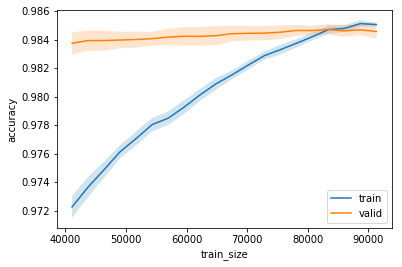

In [96]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

*При такой постановке задачи - нет. Во-первых, accuracy в такой несбалансированной задаче - не очень информативная метрика. Как мы уже видели, константный алгоритм дает accuracy порядка 0.98. Сложно увидеть на графике, улучшается ли качество.*

*Поскольку мы подозреваем, что плохой классификатор будет вести себя как константный, т.е. относить всех пользователей не к текущему классу, стоит посмотреть на метрику recall, которая покажет способность не относить пользователя 128 к классу 0:*

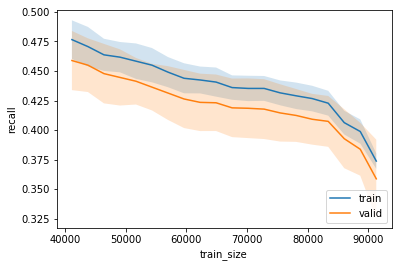

In [100]:
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128, train_sizes=train_sizes, cv=skf, 
                                              scoring='recall')
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='recall')

*Precision, способность не относить других пользователей к классу 1, при этом растет:*

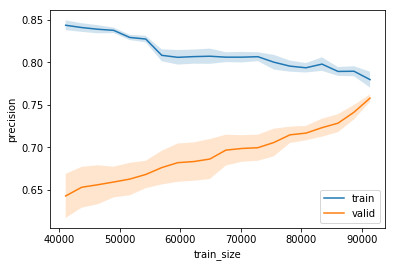

In [101]:
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128, train_sizes=train_sizes, cv=skf, 
                                              scoring='precision')
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='precision')

*Иными словами, классификатор стремится к константному, определяя все больше сессий к классу 0 - и пользователя 128, и других пользователей. Вспоминая о том, что классификатор обучался в другой постановке задачи, с максимизацией accuracy по всем пользователям, вероятно, классификатор пытался сконцентрироваться на правильной классификации более явных примеров.*

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.